In [1]:
import os
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
def load_data(file_path, encode = 'gbk'):
    df = pd.read_csv(file_path ,encoding=encode)
    columns = df.columns
    df.fillna(df.mean(numeric_only=True) ,inplace=True)
    return df

In [3]:
synth_data_path = 'synth_data'
real_data_path = '../temp/final'
id = 'chen'
#生成data路径
synth_data_path = os.path.join(synth_data_path, id, 'base.csv')
real_data_path = os.path.join(real_data_path, id, 'final(english).csv')

synth_data = load_data(synth_data_path, encode='utf-8')
real_data = load_data(real_data_path)

In [4]:
# 选择需要归一化的列（如果有多个列）
columns_to_normalize = ['amount', 'temperature', 'station_pressure', 'sea_level_pressure', 'relative_humidity', 'windspeed',
                       'timestamp']

# 初始化 MinMaxScaler
real_scaler = MinMaxScaler()
synth_scaler = MinMaxScaler()

# 对需要归一化的列进行归一化操作
real_data[columns_to_normalize] = real_scaler.fit_transform(real_data[columns_to_normalize])
synth_data[columns_to_normalize] = synth_scaler.fit_transform(synth_data[columns_to_normalize])

In [5]:
cols = ["amount", "temperature", "station_pressure", "sea_level_pressure", 
        "relative_humidity", "windspeed","special_weather", "timestamp"
]

real_data_plot = real_data[cols]
synth_data_plot = synth_data[cols]

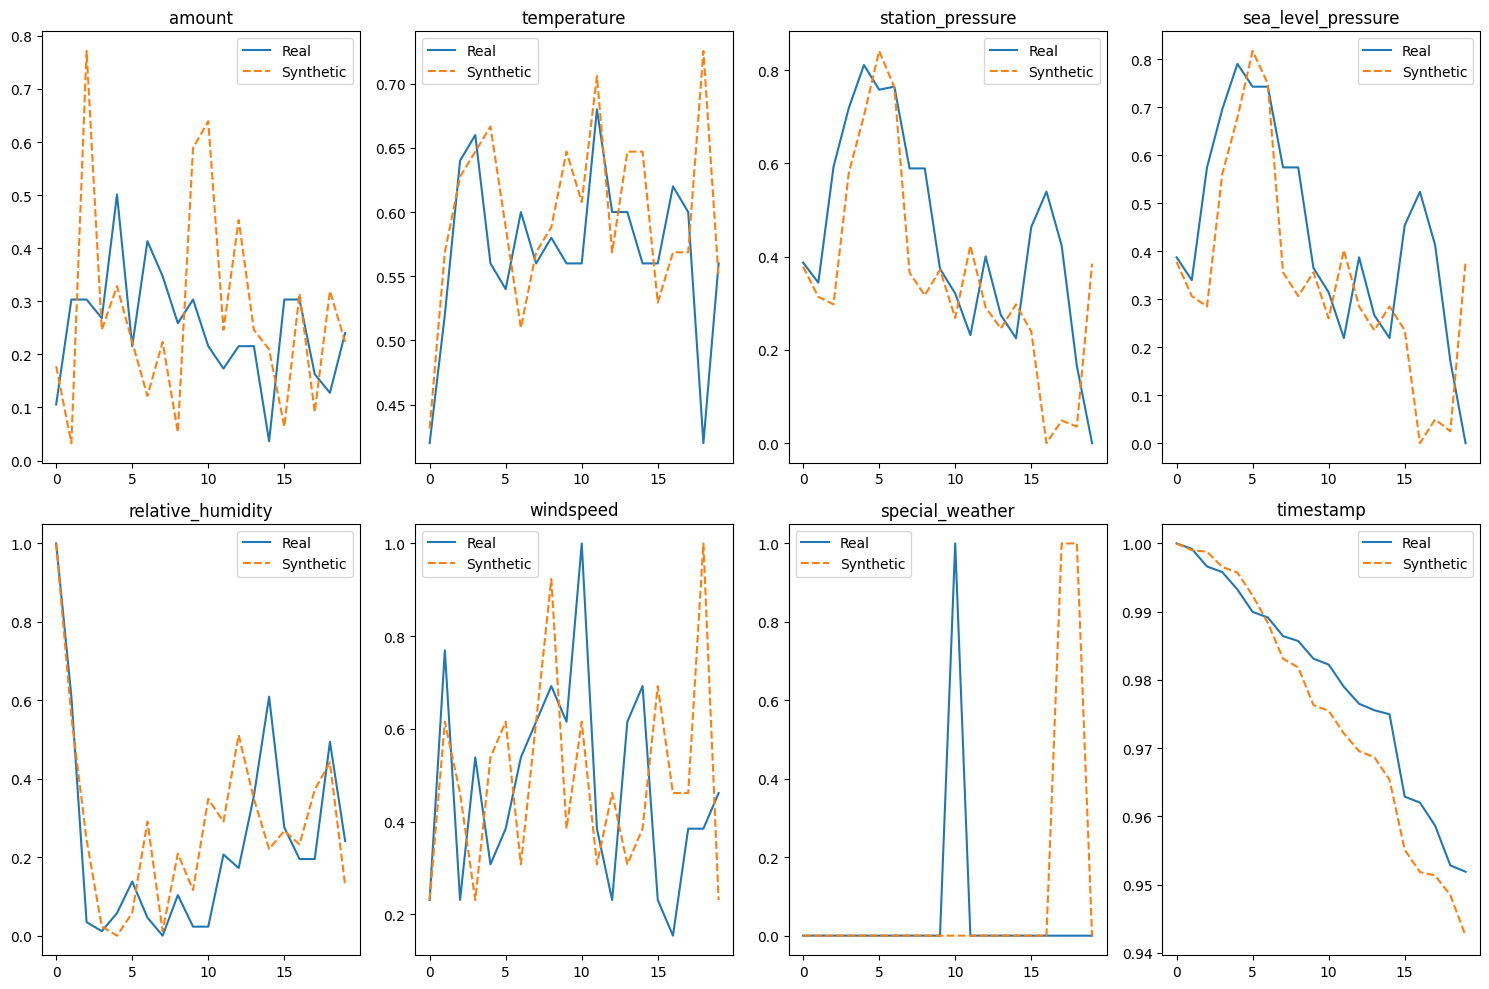

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
axes=axes.flatten()

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': real_data_plot.iloc[:20, j],
                   'Synthetic': synth_data_plot.iloc[:20, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

if not os.path.exists("./synth_data/chen/img"):
    os.makedirs("./synth_data/chen/img")
plt.savefig('synth_data/chen/img/comparison_gan_outputs.png', dpi=200)

In [8]:
feature_to_analyse = ["amount", "weekday", "temperature", "station_pressure",
                      "sea_level_pressure", "relative_humidity", "windspeed",
                      "timestamp","merchant_code"
]

real_data = real_data[feature_to_analyse]
synth_data = synth_data[feature_to_analyse]

In [9]:
'''
dataset 代表特征数据
start_index 代表从数据的第几个索引值开始取
history_size 滑动窗口大小
end_index 代表数据取到哪个索引就结束
target_size 代表选取未来某一时间点还是时间段
step 代表在滑动窗口中每隔多少步取一组特征
'''
 
def TimeSeries(dataset, start_index, history_size, end_index, step,
               target_size):
    
    data = []  # 保存特征数据
    
    start_index = start_index + history_size  # 第一次的取值范围[0:start_index]
    
    # 如果没有指定滑动窗口取到哪个结束，那就取到最后
    if end_index is None:
        # 数据集最后一块是用来作为标签值的，特征不能取到底
        end_index = len(dataset) - target_size
        
    # 滑动窗口的起始位置到终止位置每次移动一步
    for i in range(start_index, end_index):
        
        # 滑窗中的值不全部取出来用，每隔60min取一次
        index = range(i-history_size, i, step)  # 第一次相当于range(0, start_index, 4)
        
        # 根据索引取出所有的特征数据的指定行
        data.append(dataset.iloc[index])
    
    # 返回划分好了的时间序列特征
    return np.array(data)

In [10]:
sample = 210
history_size = 8
target_size =  0
step = 1  

real_data =  TimeSeries(dataset=real_data, start_index=0, history_size=history_size, end_index=sample,
                    step=step, target_size=target_size)

synth_data =  TimeSeries(dataset=synth_data, start_index=0, history_size=history_size, end_index=sample,
                    step=step, target_size=target_size)

print('real_data_shape:', real_data.shape)  
print('synth_data_shape:', synth_data.shape)  

real_data_shape: (202, 8, 9)
synth_data_shape: (202, 8, 9)


In [11]:
real_data_reduced = real_data.reshape(-1, history_size) #(2538, 9)
synth_data_reduced = synth_data.reshape(-1,history_size) #(2538, 9)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

pca.fit(real_data_reduced)

pca_real = pd.DataFrame(pca.transform(real_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((real_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

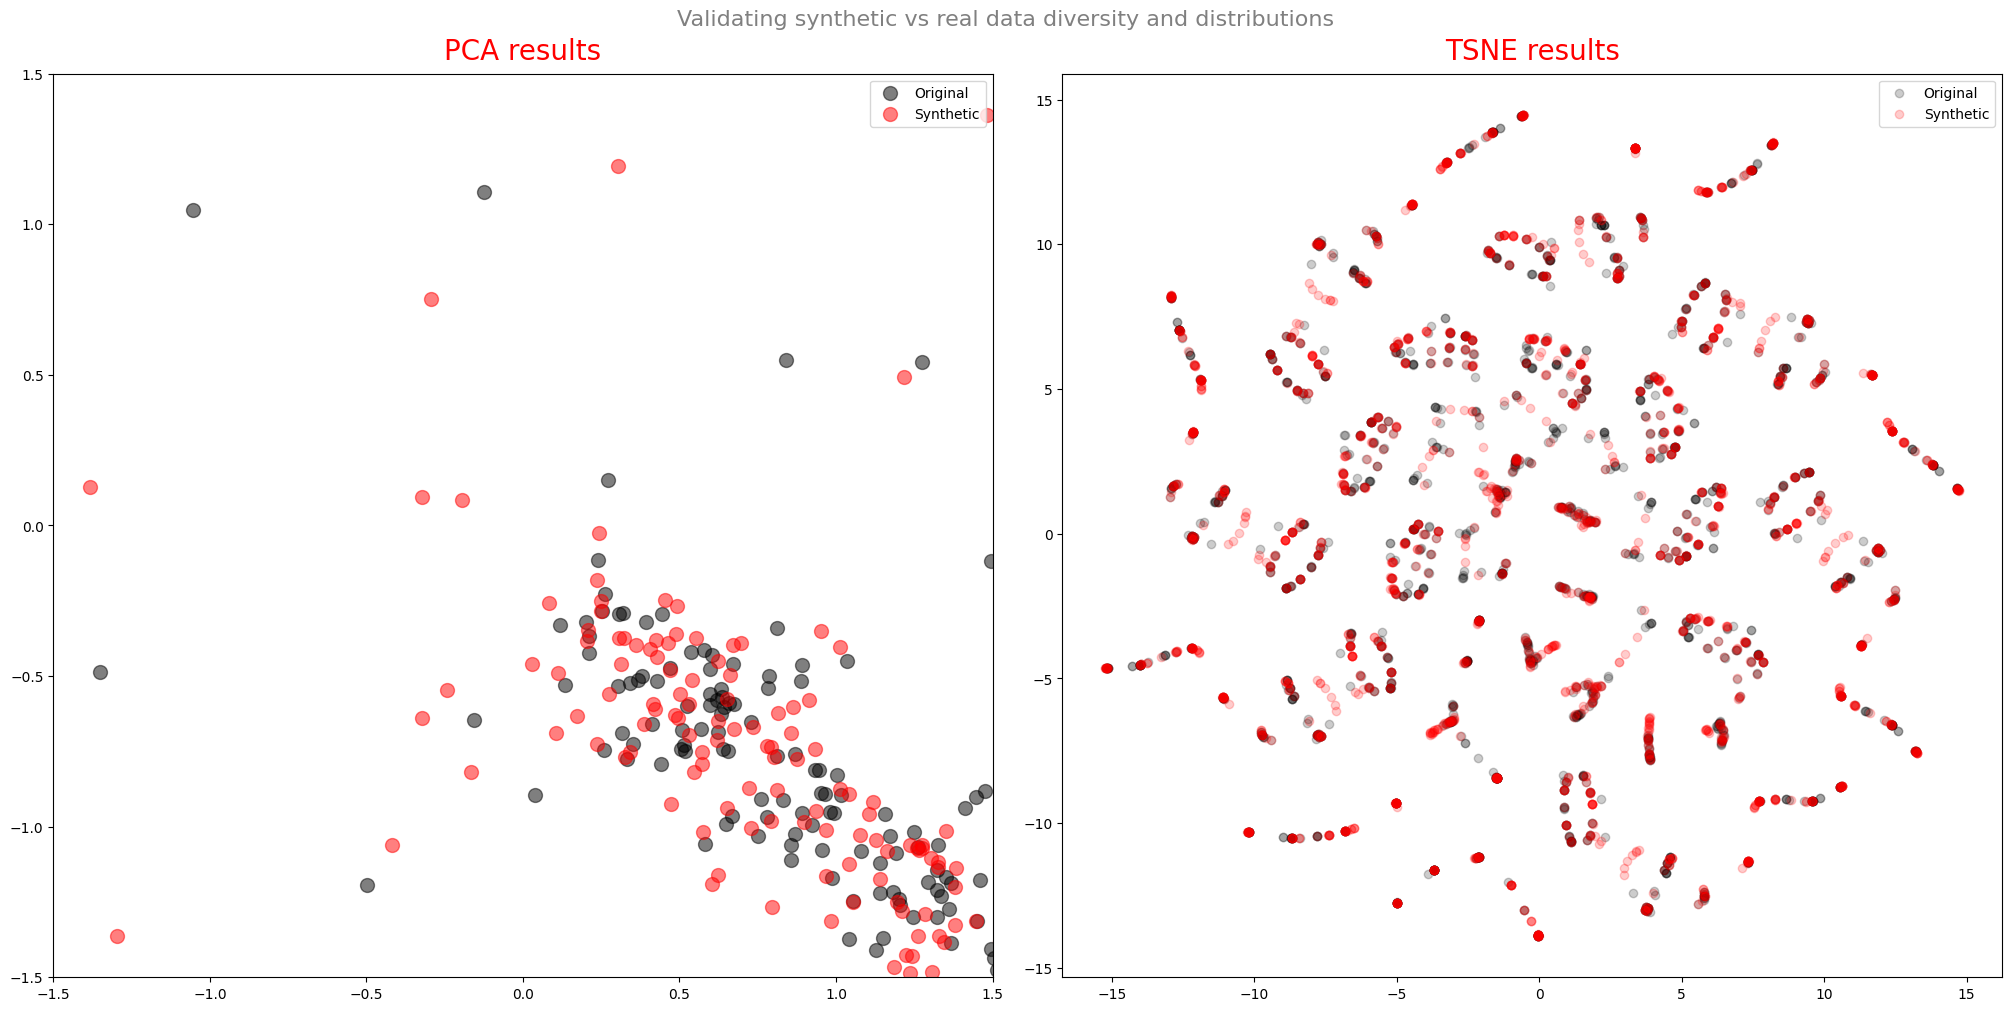

In [13]:
import matplotlib.gridspec as gridspec

fig = plt.figure(constrained_layout=True, figsize=(20, 10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

# PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:, 1].values,
            c='black', alpha=0.5, label='Original', s=100)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

plt.scatter(pca_synth.iloc[:, 0], pca_synth.iloc[:, 1],
            c='red', alpha=0.5, label='Synthetic', s=100)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

# t-SNE scatter plot
plt.scatter(tsne_results.iloc[:1818, 0].values, tsne_results.iloc[:1818, 1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[1818:, 0], tsne_results.iloc[1818:, 1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

if not os.path.exists("./synth_data/chen/img"):
    os.makedirs("./synth_data/chen/img")
plt.savefig('synth_data/chen/img/synthetic_vs_real_data_diversity_and_distributions.png', dpi=200)